In [2]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from PIL import Image
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from typing import Tuple, List, Dict
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import Quaternion
import pickle
import math
dataroot = 'nuscenes_mini'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

Loading NuScenes tables for version v1.0-mini ...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
def getCam_annotation(anntoken: str,
                      margin: float = 10,
                      view: np.ndarray = np.eye(4),
                      box_vis_level: BoxVisibility = BoxVisibility.ANY) -> None:

    ann_record = nusc.get('sample_annotation', anntoken)
    sample_record = nusc.get('sample', ann_record['sample_token'])
    
    # Figure out which camera the object is fully visible in (this may return nothing)
    boxes, cam = [], []
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                                selected_anntokens=[anntoken])
        if len(boxes) > 0:
            break  # We found an image that matches. Let's abort.
    #assert len(boxes) > 0, "Could not find image where annotation is visible."
    #assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"
    
    if len(boxes) < 1:
        print('no boxes matches')
        return None, None
    if len(boxes) > 1:
        print('Too many boxes matches')
        return None, None

    cam = sample_record['data'][cam]
    
    data_path, cam_boxes, camera_intrinsic = nusc.get_sample_data(cam, selected_anntokens=[anntoken])
    
    return boxes

In [5]:
pedestrians = list(filter(lambda d: d['category_name'] in 
                          ['human.pedestrian.adult','human.pedestrian.child',
                           'human.pedestrian.construction_worker','human.pedestrian.personal_mobility',
                           'human.pedestrian.police_officer'], nusc.sample_annotation))

In [6]:
pedestrians=list(filter(lambda d: d['visibility_token'] in 
                          ['3','4'], pedestrians))

In [7]:
len(pedestrians)

3150

In [103]:
ann_sample = pedestrians[0]
ann_sample

KeyError: 'data'

In [105]:
sample = nusc.get('sample', ann_sample['sample_token'])
sample

{'token': 'cd21dbfc3bd749c7b10a5c42562e0c42',
 'timestamp': 1532402935197541,
 'prev': '2afb9d32310e4546a71cbe432911eca2',
 'next': '88449a5cb1644a199c1c11f6ac034867',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '6408591d3d9a4ddbab62f2d0f22d50b4',
  'RADAR_FRONT_LEFT': '02afde965e3e41bb9d205e70d6aa8065',
  'RADAR_FRONT_RIGHT': '8a8f5f4e8e49487f97ffa0defaa00c5a',
  'RADAR_BACK_LEFT': '376fd2d62342405f9aa6e408104481e6',
  'RADAR_BACK_RIGHT': 'e5899e2aa43f42e7a660e37a12cc2585',
  'LIDAR_TOP': 'f582c6d34c8b403c8f3b66a8bb896892',
  'CAM_FRONT': 'e0bc3ff06fe348fdb56039c640be0ac3',
  'CAM_FRONT_RIGHT': 'ebf7973f82f145df97b67c7af559b1a8',
  'CAM_BACK_RIGHT': '8b4d4aef4cdd4dc68340549326282c9a',
  'CAM_BACK': '4d41b098087948bda699b40ff62ed88a',
  'CAM_BACK_LEFT': 'ad15f0f3a94040d5844111b364eb02c4',
  'CAM_FRONT_LEFT': '15e06c451f134165917f0cbbcdf81026'},
 'anns': ['70aecbe9b64f4722ab3c230391a3beb8',
  'da306054444b43579e03d77afaf56f86',
  '55c1b3e5436c499aafa3364

In [ ]:
sd_token = my_sample['data'][cam]
name, boxes_gt, boxes_3d, dds, kk = extract_from_token(sd_token)

Extract the sample data token.
There is a missing link between an annotation and its sample data.

In [136]:
# Figure out in which camera the object is fully visible in. (i.e. Go from sample to sample_data. This is missing)
def get_sensor(ann_record):
    sample_record = nusc.get('sample', ann_record['sample_token'])
    boxes, cam = [], []
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=1,
                                           selected_anntokens=[ann_record['token']])
        if len(boxes) > 0:
            break  # We found an image that matches. Let's abort.
    assert len(boxes) > 0, "Could not find image where annotation is visible. Try using e.g. BoxVisibility.ANY."
    assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"
    return cam, sample_record


In [257]:
def get_sensor_annotations(ann_token):
    """From a single annotation return all the annotations from the same sensor in the same image"""
    
    cam, sample_record = get_sensor(ann_token)
    print(cam)
    ann_tokens = []
    for ann_token in sample_record['anns']:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=1,selected_anntokens=[ann_token])
        if len(boxes) > 0:
            ann_tokens.append(ann_token)
    return ann_tokens

In [123]:
def get_filename(sample_record, cam):
    sd_token = sample_record['data'][cam]
    sample_data = nusc.get('sample_data', sd_token)
    filename = sample_data['filename']
    return filename
filename = get_filename(sample_record, cam)
print(filename)

samples/CAM_BACK_LEFT/n015-2018-10-08-15-36-50+0800__CAM_BACK_LEFT__1538984238947423.jpg


In [362]:
name = 'samples/CAM_FRONT_LEFT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_LEFT__1533151609904799.jpg'
name = 'samples/CAM_BACK/n015-2018-10-08-15-36-50+0800__CAM_BACK__1538984236437525.jpg'

label: nan, score: nan, xyz: [7.95, 1.10, 25.02], wlh: [4.74, 1.34, 1.40], rot axis: [0.68, -0.52, 0.52], ang(degrees): 110.41, ang(rad): 1.93, vel: nan, nan, nan, name: static_object.bicycle_rack, token: f3a1088e4d714c229e3948e2f352f715
-74.13419699310916


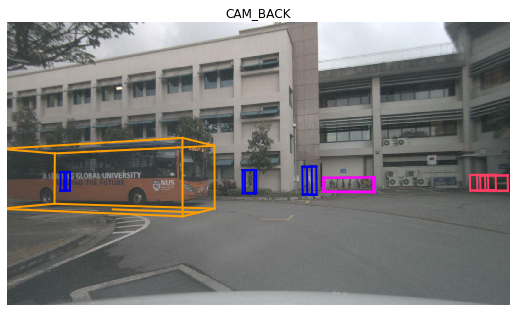

In [365]:
def quaternion_yaw(q: Quaternion, in_image_frame: bool=True) -> float:

    if in_image_frame:
        v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))
        yaw = -np.arctan2(v[2], v[0])
    else:
        v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))
        yaw = np.arctan2(v[1], v[0])
    return yaw

def find_yaw_angle_orig():
    sd1 = [sd for sd in nusc.sample_data if sd['filename'] == name][0]
              
    _, boxes, _ = nusc.get_sample_data(sd1['token'], box_vis_level=0)
    box = boxes[1]
    print(box)
    yaw = quaternion_yaw(box.orientation) / np.pi * 180
    print(yaw)
    nusc.render_sample_data(sd1['token']); plt.show()
    
find_yaw_angle_orig()
  

In [348]:
num = 100
ann_record = pedestrians[num]
ann_token = ann_record['token']
new_angle = find_yaw_angle(ann_token)
new_angle

label: nan, score: nan, xyz: [390.01, 1122.87, 1.03], wlh: [0.65, 0.71, 1.61], rot axis: [0.00, 0.00, 1.00], ang(degrees): 171.53, ang(rad): 2.99, vel: nan, nan, nan, name: human.pedestrian.adult, token: b0df1a4a43ca4ecfbffa39442b6312f2


171.52799999965032

In [313]:
num = 4
# Render all the instances of a certain sensor
# ann_tokens = get_sensor_annotations(ann_record) 
ann_record = pedestrians[num]

# ann_token = ann_tokens[2]
angle, correction = find_orientation(ann_token)
new_angle = find_yaw_angle(ann_token)


print("Real angle: {:.2f}\nPerceived angle:{:.1f}".format(angle, angle-correction))
print("Quaternion angle: {:.1f}".format(float(new_angle)))

label: nan, score: nan, xyz: [373.26, 1130.42, 1.15], wlh: [0.62, 0.67, 1.64], rot axis: [0.00, 0.00, -1.00], ang(degrees): 21.09, ang(rad): 0.37, vel: nan, nan, nan, name: human.pedestrian.adult, token: a1721876c0944cdd92ebc3c75d55d693
Real angle: 228.80
Perceived angle:203.2
Quaternion angle: -21.1


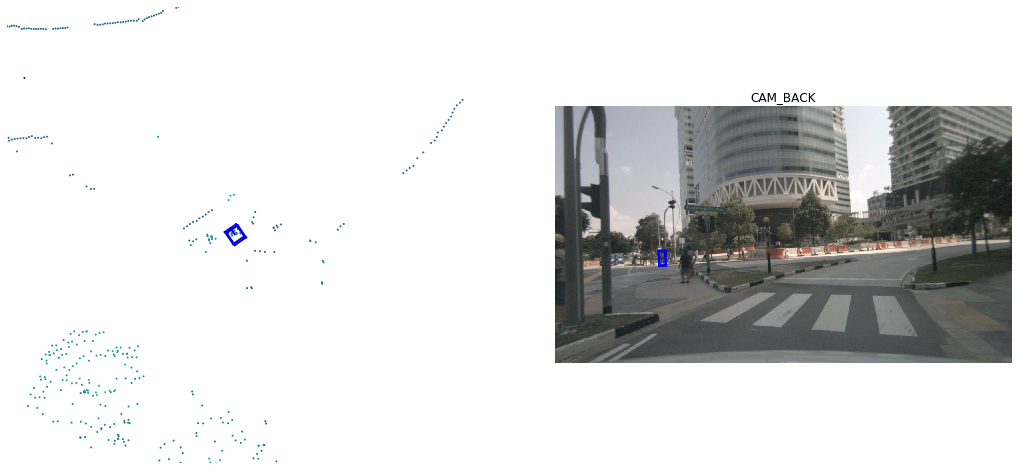

In [305]:
nusc.render_annotation(ann_token)

In [308]:
from pyquaternion import Quaternion

def quaternion_yaw(q: Quaternion, in_image_frame: bool=True) -> float:

    if in_image_frame:
        v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))
        yaw = -np.arctan2(v[2], v[0])
    else:
        v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))
        yaw = np.arctan2(v[1], v[0])

    return yaw

def find_yaw_angle(ann_token):
    box = nusc.get_box(ann_token)
    print(box)
#     yaw = quaternion_yaw(box.orientation, False) / np.pi * 180abs
    yaw = np.array(Quaternion(box.orientation.elements).yaw_pitch_roll[0]) / np.pi * 180
    return yaw
    

Real angle: 120.81339859560649
Perceived angle:114.16027306195018


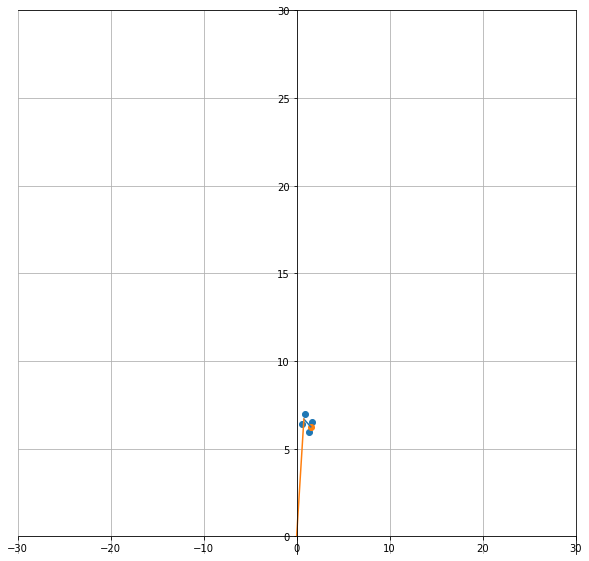

In [55]:
boxes=getCam_annotation(token)
show_orientation(token)



In [59]:
def extract_from_token(sd_token):

    boxes_gt = []
    dds = []
    boxes_3d = []
    path_im, boxes_obj, kk = nusc.get_sample_data(sd_token, box_vis_level=1)  # At least one corner
    kk = kk.tolist()
    name = os.path.basename(path_im)
    for box_obj in boxes_obj:
        if box_obj.name[:6] != 'animal':
            general_name = box_obj.name.split('.')[0] + '.' + box_obj.name.split('.')[1]
        else:
            general_name = 'animal'
        if general_name in select_categories('all'):
            box = project_3d(box_obj, kk)
            dd = np.linalg.norm(box_obj.center)
            boxes_gt.append(box)
            dds.append(dd)
            box_3d = box_obj.center.tolist() + box_obj.wlh.tolist()
            boxes_3d.append(box_3d)

    return name, boxes_gt, boxes_3d, dds, kk

In [27]:
def show_orientation(pedestrian_token):
    
    b_corners = getCam_annotation(pedestrian_token)[0].bottom_corners()
    center = getCam_annotation(pedestrian_token)[0].center
    back_point=[(b_corners[0,2]+b_corners[0,3])/2,(b_corners[2,2]+b_corners[2,3])/2]
    
    x=b_corners[0,:]-back_point[0]
    y=b_corners[2,:]-back_point[1]
    fig, ax = plt.subplots(1,figsize=(10,10))
    ax.scatter(x+center[0],y+center[2])
    ax.scatter(((x[0]+x[1])/2)+center[0],((y[0]+y[1])/2)+center[2])
    ax.plot([0+center[0],((x[0]+x[1])/2)+center[0]],[0+center[2],((y[0]+y[1])/2)+center[2]])
    ax.plot([0,center[0]],[0,center[2]])
    ax.grid(True, which='both')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_xlim(-30, 30)
    ax.set_ylim(-1, 30)

    

In [45]:
def find_orientation(pedestrian_token):
    
    b_corners = getCam_annotation(pedestrian_token)[0].bottom_corners()
    center = getCam_annotation(pedestrian_token)[0].center
    back_point=[(b_corners[0,2]+b_corners[0,3])/2,(b_corners[2,2]+b_corners[2,3])/2]
    
    x=b_corners[0,:]-back_point[0]
    y=b_corners[2,:]-back_point[1]
    
    angle=math.atan2((x[0]+x[1])/2,(y[0]+y[1])/2)*180/3.14
    angle=(angle+360)%360
    correction=math.atan2(center[0],center[2])*180/3.14
    return angle, correction

In [12]:
def get_bounds(box, view: np.ndarray = np.eye(3), normalize: bool = False):
       
    corners = view_points(box.corners(), view, normalize=normalize)[:2, :]

    x_bounds=[min(corners[0]),max(corners[0])]
    y_bounds=[min(corners[1]),max(corners[1])]
    return [x_bounds, y_bounds]
        

In [13]:
def get_pixel_bbox_and_filename(anntoken: str,
                      margin: float = 10,
                      view: np.ndarray = np.eye(4),
                      box_vis_level: BoxVisibility = BoxVisibility.ANY) -> None:

    ann_record = nusc.get('sample_annotation', anntoken)
    sample_record = nusc.get('sample', ann_record['sample_token'])

    boxes, cam = [], []
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                                selected_anntokens=[anntoken])
        if len(boxes) > 0:
            break  # We found an image that matches. Let's abort.
    #assert len(boxes) > 0, "Could not find image where annotation is visible. Try using e.g. BoxVisibility.ANY."
    #assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"
    
    if len(boxes) < 1:
        print('no boxes matches')
        return None, None
    if len(boxes) > 1:
        print('Too many boxes matches')
        return None, None
    
    cam = sample_record['data'][cam]

    data_path, boxes, camera_intrinsic = nusc.get_sample_data(cam, selected_anntokens=[anntoken])
    
    pixel_boxes=[]
    for box in boxes:
        pixel_boxes.append(get_bounds(box, view=camera_intrinsic, normalize=True))
        
    return data_path , pixel_boxes
        

228.22963757505912

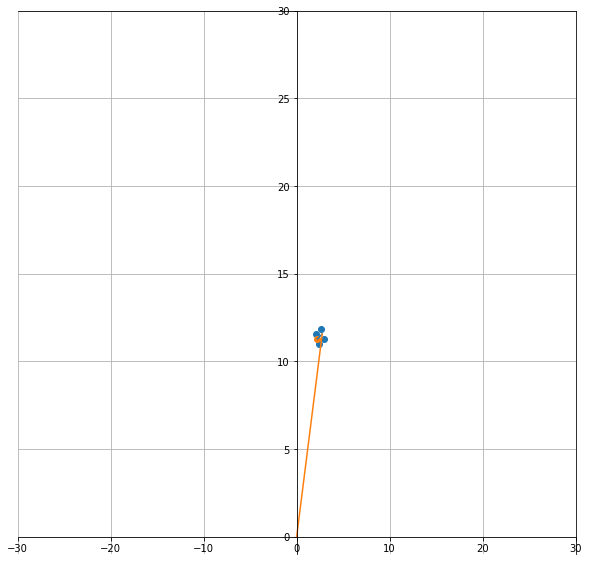

In [14]:
show_orientation('add79052b354471fbc7e231b95e3fdd9')
find_orientation('add79052b354471fbc7e231b95e3fdd9')

In [15]:
useful_data = []
for i, pedestrian in enumerate(pedestrians):
    data = {}
    update_progress(i / len(pedestrians))
    [data['filename'], data['box']]=get_pixel_bbox_and_filename(pedestrian['token'])
    if data['filename'] != None:
        data['orientation']=find_orientation(pedestrian['token'])
        box=getCam_annotation(pedestrian['token'])
        data['distance']=box[0].center[2]
        data['position']=box[0].center
        data['dimensions']=pedestrian['size']
        data['pedestrian_token']=pedestrian['token']
        useful_data.append(data)
    

Progress: [####################] 100.0%


In [ ]:
for i, data in enumerate(useful_data):
    update_progress(i/len(useful_data))
    anntoken = data['pedestrian_token']
    ann_record = nusc.get('sample_annotation', anntoken)
    sample_record = nusc.get('sample', ann_record['sample_token'])
    assert 'LIDAR_TOP' in sample_record['data'].keys(), 'No LIDAR_TOP in data, cant render'

    #fig, axes = plt.subplots(1, 1, figsize=(18, 9))


    boxes, cam = [], []
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=BoxVisibility.ANY,
                                                selected_anntokens=[anntoken])
        if len(boxes) > 0:
            break  # We found an image that matches. Let's abort.
    assert len(boxes) > 0, "Could not find image where annotation is visible. Try using e.g. BoxVisibility.ANY."
    assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"

    cam = sample_record['data'][cam]


    data_path, boxes, camera_intrinsic = nusc.get_sample_data(cam, selected_anntokens=[anntoken])
    data['cam intrinsic'] = camera_intrinsic

In [16]:
len(useful_data)

130211

In [17]:
%%time
pickle_out = open("orientations_gt.pickle","wb")
pickle.dump(useful_data, pickle_out)
pickle_out.close()

CPU times: user 2.19 s, sys: 171 ms, total: 2.36 s
Wall time: 2.36 s


In [18]:
pickle_in = open("orientations_gt.pickle","rb")
test = pickle.load(pickle_in)

In [19]:
len(test)

130211

In [20]:
useful_data[45996]

{'filename': 'data/sets/nuscenes/samples/CAM_FRONT_LEFT/n015-2018-07-11-11-54-16+0800__CAM_FRONT_LEFT__1531281871654857.jpg',
 'box': [[[1018.9852686959061, 1151.1913301326076],
   [430.78143832766614, 679.339470202549]]],
 'orientation': 117.64270939537286,
 'distance': 9.154579076802257,
 'position': array([1.8596532 , 0.50857714, 9.15457908]),
 'dimensions': [0.626, 0.634, 1.687],
 'pedestrian_token': '65d4c0df7e5840ca978dd47bec8e2520'}